# Clasificación de dígitos usando Redes Convolucionales y Keras

## 1 - El set de datos

En este tutorial implementaremos una red convolucional para clasificar los dígitos del 0 al 9. Para ello usaremos el set de datos [MNIST](https://www.kaggle.com/datasets/hojjatk/mnist-dataset), que contiene un total de 70.000 imágenes escritas a mano por diferentes personas.



Al final de este tutorial tendremos claro:
1. Cómo funciona [LeNet-5](https://www.kaggle.com/code/blurredmachine/lenet-architecture-a-complete-guide), la red convolucional usada en este tutorial
2. Cómo implementar esta red convolucional usando la librería Keras
3. Cómo evaluar el desempeño de la red

En primer lugar, veamos cómo es LeNet-5.

## 2 - LeNet-5

Esta red es la precursora de todas las redes convolucionales usadas en la actualidad. Fue diseñada por [Yann LeCun] a finales de los años 90, con el fin de clasificar dígitos (del 0 al 9) escritos a mano.

Esta red tiene como entradas imágenes de 28x28x1: 28 filas, 28 columnas y 1 sólo canal de color, es decir imágenes en escala de gris.


Como se observa en la figura de arriba, la red cuenta con dos bloques de procesamiento:
- Las *capas convolucionales* que se encargan de extraer características de las imágenes
- Una *red neuronal* fully connected, que toma dichas características y permite clasificar la imagen en uno de los posibles 10 dígitos (del 0 al 9)

Además, podemos observar las siguientes características:
- Después de realizar convoluciones se usa siempre la función de activación *ReLU*
- El *max-pooling* (obtencion del valor mayor) se realiza después de las convoluciones
- Las *dimensiones espaciales* (número de filas y columnas) de las imágenes se reducen entre una capa y otra, mientras que la profundidad (correspondiente a las características extraídas) aumenta entre una capa y otra

Las redes convolucionales usadas en la actualidad implementan una lógica similar a la de LeNet-5.

## 3 - Implementación en Keras

### 3.1 - Librerías requeridas

En primer lugar se importa la librería Numpy y se ajusta la semilla del generador aleatorio para garantizar la reproducibilidad del entrenamiento. También importaremos la librería Matplotlib, para poder visualizar las imágenes del set de datos :

In [16]:
import numpy as np
np.random.seed(2)

import matplotlib.pyplot as plt
%matplotlib inline

A continuación importamos las funciones *Sequential*, *Conv2D*, *MaxPooling2D*, *Flatten*, *Dense* y *SGD* de Keras:

In [17]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD

### 3.2 - Pre-procesamiento del set de datos

La función *mnist* de Keras permite leer el set de datos y crear automáticamente los sets de entrenamiento y validación. El primero de ellos tendrá 60,000 imágenes (cada una de 28x28) con sus correspondientes categorías, mientras que el segundo tendrá 10,000 datos:

In [18]:
(x_train, y_train), (x_test,y_test) = mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Los pixeles en las imágenes (tanto de entrenamiento como de validación) tienen valores entre 0 y 255; sin embargo, para garantizar la convergencia del entrenamiento es necesario normalizar estos valores entre 0 y 1:

In [19]:
# 8 bits significa
mybits = 2*2*2*2*2*2*2*2
print(mybits)

256


In [20]:
x_train = x_train/255.0
x_test = x_test/255.0

También se deben codificar *y_train* y *y_test* en el formato *one-hot*:

In [21]:
#1 hot encoding: 1 0 0 0 0 0 0...
# 0 1 0 0 0 0

nclases = 10
y_train = to_categorical(y_train,nclases)
y_test = to_categorical(y_test,nclases)

Finalmente, podemos visualizar un ejemplo de imagen dentro del dataset:

In [22]:
nimagen = 102 #99 #71
plt.imshow(x_train[nimagen,:].reshape(28,28), cmap='gray_r')
plt.title('Imagen ejemplo - Categoría: ' + str(np.argmax(y_train[nimagen])))
plt.axis('off')

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

Por defecto, Keras requiere cada dato de entrada en el formato nimagenes x nfilas x ncolumnas x ncanales, donde ncanales = 1 por ser imágenes en escala de gris. Se debe modificar el tamaño de *x_train* y *x_test* para cumplir con este requerimiento:

In [23]:
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### 3.3 - Creación del modelo

En la siguiente tabla se resumen las características de cada capa a implementar:
    
| **Capa**          | **Características**                            |
|-------------------|------------------------------------------------|
| CONV 1            | 6 filtros, 5x5, p=0, s=1, activación: ReLU     |
| MAX-POOLING 1     | 6 filtros, 2x2, p=0, s=2, activación: Ninguna  |
| CONV 2            | 16 filtros, 5x5, p=0, s=1, activación: ReLU    |
| MAX-POOLING 2     | 16 filtros, 2x2, p=0, s=2, activación: Ninguna |
| FLATTEN           | Simplemente convierte una matriz en un vector  |
| FULLY CONNECTED 1 | 120 neuronas, activación: ReLU                 |
| FULLY CONNECTED 2 | 84 neuronas, activación: ReLU                  |
| SALIDA            | 10 categorías, activación: softmax (valor mayor de probabilidad)             |



Creemos el contenedor del modelo usando *Sequential()*:

In [24]:
modelo = Sequential()

Y añadimos, de forma secuencial, las diferentes capas de la red convolucional. En particular, usamos *Conv2D* para las capas convolucionales y *MaxPooling2D* para el *max-pooling*, junto con *Flatten* y *Dense* para la etapa de clasificación con redes neuronales y la capa de salida:

In [25]:
# CONV1 Y MAX-POOLING1
modelo.add(Conv2D(filters=6, kernel_size=(5,5), activation='relu', input_shape=(28,28,1)))
modelo.add(MaxPooling2D(pool_size=(2,2)))

# CONV2 Y MAX-POOLING2
modelo.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu'))
modelo.add(MaxPooling2D(pool_size=(2,2)))

# Aplanar, FC1, FC2 y salida
modelo.add(Flatten())
modelo.add(Dense(120,activation='relu'))
modelo.add(Dense(84,activation='relu'))
modelo.add(Dense(nclases,activation='softmax'))

### 3.4 - Compilación del modelo

En esta etapa definimos el optimizador a usar (gradiente descendente, tasa de aprendizaje = 0.1), así como la función de error (entropía cruzada) y la métrica de desempeño (precisión):

In [26]:
sgd = SGD(learning_rate=0.01) #0.1
modelo.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

### 3.5 - Entrenamiento

Realicemos el entrenamiento usando 10 iteraciones, una tasa de aprendizaje de 0.1 y un tamaño de lote (*batch_size*) de 128:

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6347 - loss: 1.2297 - val_accuracy: 0.8951 - val_loss: 0.3576
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9045 - loss: 0.3129 - val_accuracy: 0.9326 - val_loss: 0.2210
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9353 - loss: 0.2123 - val_accuracy: 0.9501 - val_loss: 0.1765
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9499 - loss: 0.1664 - val_accuracy: 0.9553 - val_loss: 0.1436
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9574 - loss: 0.1399 - val_accuracy: 0.9652 - val_loss: 0.1237
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9628 - loss: 0.1215 - val_accuracy: 0.9698 - val_loss: 0.1018
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9668 - loss: 0.1087 - val_accuracy: 0.9720 - val_loss: 0.0954
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9694 - loss: 0.1000 - val_accuracy: 0.

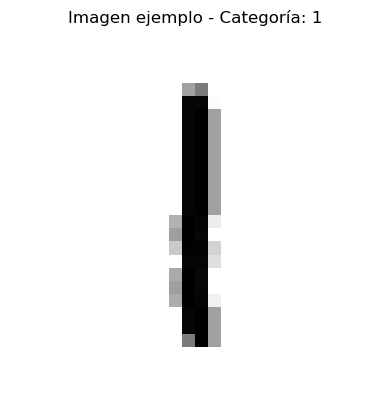

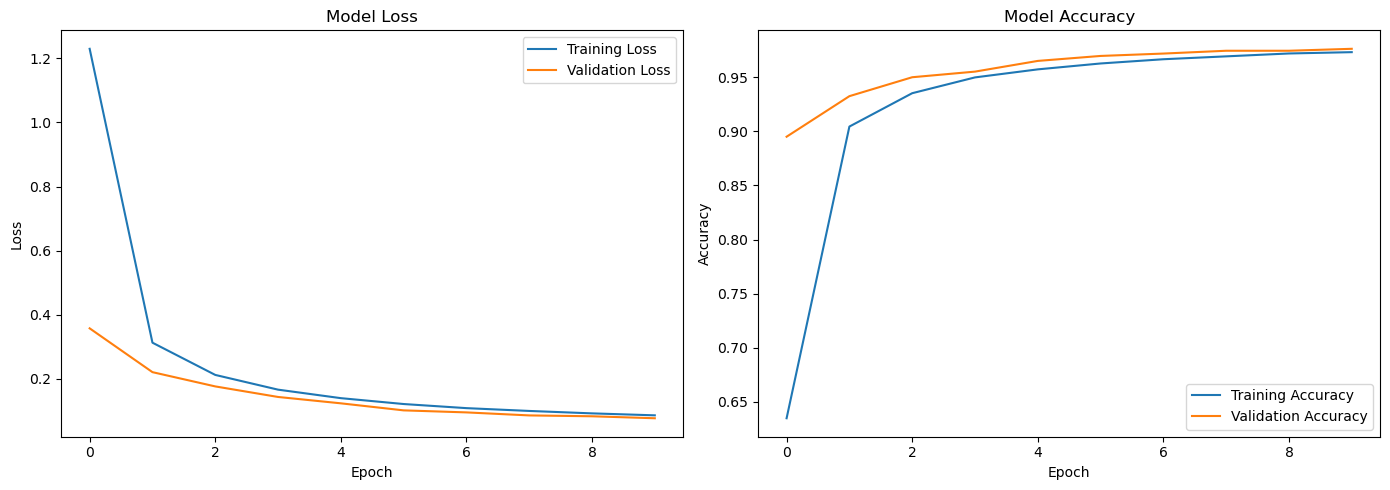

In [27]:
import matplotlib.pyplot as plt

# Training parameters
nepochs = 10
tam_lote = 128  # batch size

# Train the model and save history
history = modelo.fit(x_train, y_train, epochs=nepochs, batch_size=tam_lote, verbose=1, validation_data=(x_test, y_test))

# Plotting training & validation loss values
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Vemos que en la última iteración, el modelo alcanza una exactitud de 99.3% para el set de entrenamiento y del 98.6% para el set de validación. Esto indica que, en promedio, de cada 100 datos, aproximadamente 1 a 2 son clasificados incorrectamente. !Nada mal!

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9753 - loss: 0.0808 - val_accuracy: 0.9756 - val_loss: 0.0809
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9769 - loss: 0.0768 - val_accuracy: 0.9793 - val_loss: 0.0694
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9783 - loss: 0.0724 - val_accuracy: 0.9803 - val_loss: 0.0657
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9786 - loss: 0.0694 - val_accuracy: 0.9805 - val_loss: 0.0626
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9801 - loss: 0.0659 - val_accuracy: 0.9799 - val_loss: 0.0642
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9803 - loss: 0.0640 - val_accuracy: 0.9805 - val_loss: 0.0583
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9817 - loss: 0.0608 - val_accuracy: 0.9811 - val_loss: 0.0630
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9820 - loss: 0.0594 - val_accuracy: 0.

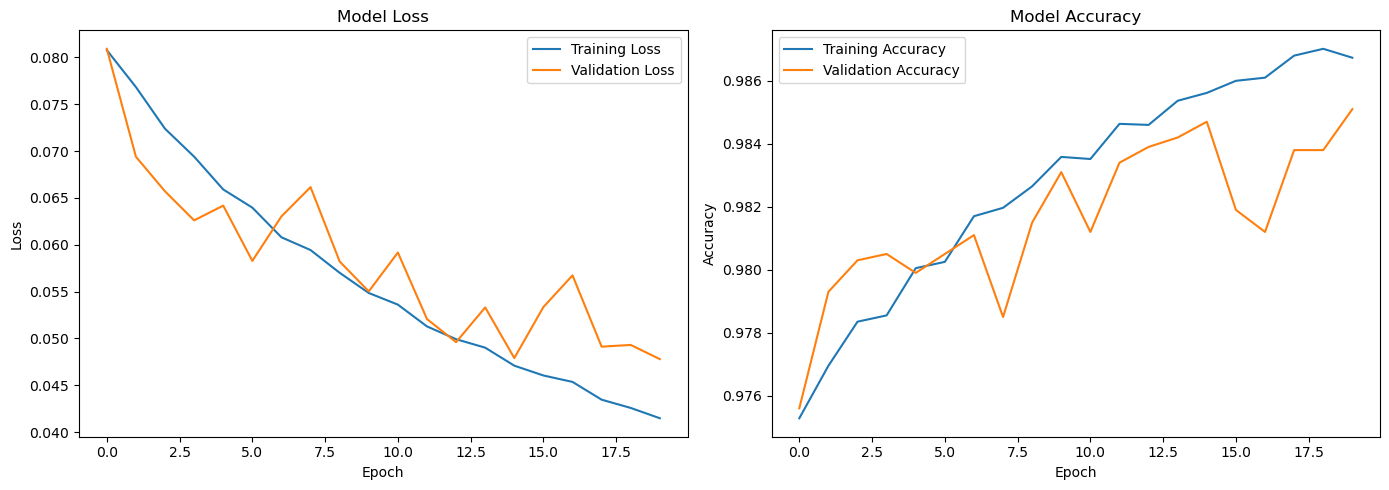

In [28]:
import matplotlib.pyplot as plt

# Training parameters
nepochs = 20
tam_lote = 128  # batch size

# Train the model and save history
history = modelo.fit(x_train, y_train, epochs=nepochs, batch_size=tam_lote, verbose=1, validation_data=(x_test, y_test))

# Plotting training & validation loss values
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## 4 - Desempeño del modelo

El valor obtenido anteriormente es una medida de desempeño global de la red convolucional en el entrenamiento, pero no nos permite verificar si algunos dígitos resultan mejor clasificados que otros. Para analizar en detalle este comportamiento, podemos usar la matriz de confusión sobre el dataset de test:

In [29]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions and convert them to class labels
y_pred = np.argmax(modelo.predict(x_test), axis=1)
y_ref = np.argmax(y_test, axis=1)

# Define class labels
etiquetas = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_ref, y_pred, labels=range(10))

# Display the confusion matrix
print(conf_matrix)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
[[ 974    0    0    0    0    0    2    1    3    0]
 [   0 1128    0    1    0    0    2    2    2    0]
 [   3    1 1015    4    1    0    0    4    4    0]
 [   1    0    0 1001    0    3    0    1    3    1]
 [   1    0    0    0  975    0    1    1    0    4]
 [   1    0    0    7    0  880    2    1    1    0]
 [   5    3    0    2    2    3  943    0    0    0]
 [   1    2    6    9    0    0    0 1001    3    6]
 [   5    0    4    4    0    3    3    6  945    4]
 [   5    2    0    5    4    0    0    4    0  989]]


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 


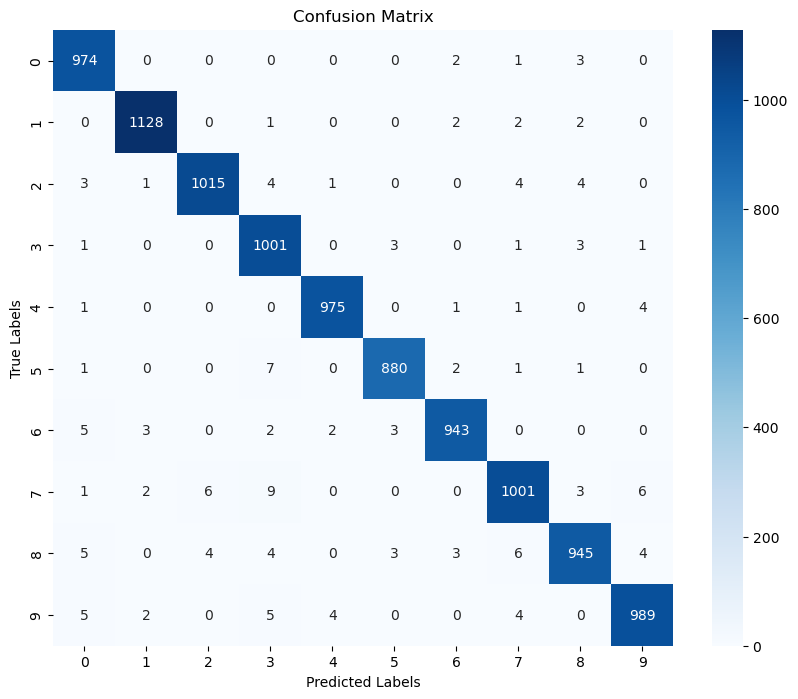

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions and convert them to class labels
y_pred = np.argmax(modelo.predict(x_test), axis=1)
y_ref = np.argmax(y_test, axis=1)

# Define class labels
etiquetas = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_ref, y_pred, labels=range(10))

# Plot the confusion matrix with labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=etiquetas, yticklabels=etiquetas)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


# Transfer Learning

Consiste en usar un modelo pre-entrenado en un conjunto de imagenes, mientras mas similares mejor (pero puede ser de otro tipo u objetos), y dejar fijo la primera parte de la red neuronal convolucional (el extractor de caracteristicas), entrenando solo el clasificador o las capas de salida con base en el dataset de interes.

Generalmente el modelo pre-entrenado es grande (profundo) y por tanto se necesitan menos epocas de entrenamiento que un modelo no pre-entrenado.


In [31]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [32]:
import tensorflow as tf
print(tf.__version__)

2.20.0


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train = tf.image.resize(x_train, (224, 224))
x_test = tf.image.resize(x_test, (224, 224))

# Set the input shape to 224x224  This is the pre-trained model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

# please change MobileNet to other like VGG16, VGG19, and EfficientNet, ResNet34, ResNet50

# Freeze the layers in the base model
base_model.trainable = False

# Build the model
inputs = tf.keras.Input(shape=(32, 32, 1))
x = tf.keras.layers.Concatenate()([inputs, inputs, inputs])  # Convert 1 channel to 3
x = base_model(x, training=False)
x = Flatten()(x)
x = Dense(120, activation='relu')(x)
x = Dense(84, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

# Plot training & validation loss values
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Optimizadores

El mas usado es Adam con o sin variable learning rate y momentum. The Adam optimizer in Keras defaults to an initial learning rate of 0.001, beta_1 of 0.9 (the equivalent of momentum), and beta_2 of 0.999 for the second moment. These values generally work well for a variety of tasks.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Customize learning rate and beta_1 (momentum)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model with Adam
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and save history
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


Why Categorical cross-entropy?

It is used in classification tasks (including multi-class like Mnist) because it calculates the difference between the predicted probability distribution and the true distribution.

Categorical cross-entropy is computed as 
−
∑
(
𝑦
log
⁡
(
𝑦
^
)
)
−∑(ylog( 
y
^
​
 )), where 
𝑦
y is the true label (one-hot encoded) and 
𝑦
^
y
^
​
  is the predicted probability from the model. This formula incorporates the exponential nature of the softmax function, which maps logits (raw model outputs) to probabilities by converting them into exponential values and normalizing them to sum to one.
